# Homework 8: Coding

**Due Tuesday December 3rd, 11:59pm.**

**This is an individual assignment.**

**Submit hw8.py file to Gradescope (you may submit as many times as you'd like before the deadline). Note that there is no autograder.**

**Please use Google Colab to maintain consistency across the class.**

# Question 2: Q-Learning

In this question, we will implement Q-learning for a classic reinforcement learning problem, MountainCar-v0.
We will be using the OpenAI Gym as our environment -- **we strongly recommend looking over the ["Getting Started" documentation](https://gym.openai.com/docs/) .**

From the [official description](https://gym.openai.com/envs/MountainCar-v0/):

> A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.


![](https://user-images.githubusercontent.com/8510097/31701297-3ebf291c-b384-11e7-8289-24f1d392fb48.PNG)


A formal description of the MountainCar task, with action and reward descriptions, can be found [here](https://github.com/openai/gym/wiki/MountainCar-v0):

>The observation space is two dimensional, `[position, velocity]` of type `Box(2)`:
- (horizontal) position: [-1.2, 0.6]
-  velocity: [-0.07, 0.07]

>The goal position is 0.5, the location of the flag on top of the hill.

>There are three possible actions of type `Discrete(3)`:
- 0: push left
- 1: no push
- 2: push right

>Reward: -1 for each time step, until the goal position of 0.5 is reached.

>Initialization: Random position from -0.6 to -0.4 with no velocity.

>Episode ends when you reach 0.5 position, or if 200 timesteps are reached. (So failure to reach the flag will result in a reward of -200).




## Dependencies and Imports

In [0]:
"""
installing dependencies
"""
!apt-get -qq -y install libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay



In [2]:
"""
Imports
"""

import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
import random
from gym import wrappers

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

import matplotlib.animation
import numpy as np
from IPython.display import HTML

# Note, you may get a few warnings regarding Tensorflow and xdpyinfo, these are to be expected

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


## 2.1 "Traditional" Q-Learning

Implement `choose_action`, `update_Q`, `update_epsilon`, and `Qlearning` below. Feel free to use any numpy utility functions you might need.

In [0]:
def discretize(state, discretization, env):
    """
    Helper function for discretizing states. This is required to map the continuous
    observation state space into discrete entries in the Q value matrix.
    
    Args:
        state (Box(2,)): the observation space state, here it is [position, velocity]
        discretization ((np.array): The discretization for each dimension of our observation space
        env: the RL environment 
        
    Returns:
        a discretized (int) version of the observation space state
    """
    env_minimum = env.observation_space.low
    state_adj = (state - env_minimum)*discretization
    discretized_state = np.round(state_adj, 0).astype(int)

    return discretized_state


def choose_action(epsilon, Q, state, env):
    """
    Choose an action according to an epsilon greedy strategy.
    
    Hint: np.argmax can be useful here.
    
    Args:
        epsilon (float): the probability of choosing a random action
        Q (np.array): The Q value matrix, here it is 3D for the two observation states and action states
        state (Box(2,)): the observation state, here it is [position, velocity]
        env: the RL environment 
        
    Returns:
        action (int): the chosen action
    """
    
    action = 0

    """TODO begin your code"""
    rand_action = np.random.rand()
    if rand_action > epsilon:
        # optimal action
        action = np.argmax(Q[state[0]][state[1]])
    else:
        # random action
        action = np.random.choice([0, 1, 2])
    
    # if np.random.random() < epsilon:
    #   action = np.random.choice([0, 1, 2])
    # else:
    #   # print(state[0])
    #   # print(state[1])
    #   action = np.argmax(Q[state[0]][state[1]])
    """TODO end your code"""
    return action


def update_epsilon(epsilon, decay_rate):
    """
    Decay epsilon by the specified rate.
    
    Args:
        epsilon (float): the probability of choosing a random action
        decay_rate (float): the decay rate (between 0 and 1) to scale epsilon by
        
    Returns:
        updated epsilon
    """
    
    """TODO begin your code"""
    epsilon = decay_rate * epsilon
    """TODO end your code"""

    return epsilon


def update_Q(Q, state_disc, next_state_disc, action, discount, learning_rate, reward, terminal):
    """
    Update Q values following the Q-learning update rule. 
    
    Be sure to handle the terminal state case.
    See lecture https://www.seas.upenn.edu/~cis520/lectures/RL.pdf, slides 39-40.
    
    Args:
        Q (np.array): The Q value matrix, here it is 3D for the two observation states and action states
        state_disc (np.array): the discretized version of the current observation state [position, velocity]
        next_state_disc (np.array): the discretized version of the next observation state [position, velocity]
        action (int): the chosen action
        discount (float): the discount factor, may be referred to as gamma
        learning_rate (float): the learning rate, may be referred to as alpha
        reward (float): the current (immediate) reward
        terminal (bool): flag for whether the state is terminal
        
    Returns:
        Q, with the [state_disc[0], state_disc[1], action] entry updated.
    """

    """TODO begin your code"""
    if terminal == False:
        Q_update = Q[state_disc[0]][state_disc[1]][action] + learning_rate * (reward + discount * (max(Q[next_state_disc[0]][next_state_disc[1]]) - Q[state_disc[0]][state_disc[1]][action]))
        Q[state_disc[0]][state_disc[1]][action] = Q_update
    else:
        Q[state_disc[0]][state_disc[1]][action] = 0

    """TODO end your code"""
    
    return Q

In [0]:
def Qlearning(Q, discretization, env, learning_rate, discount, epsilon, decay_rate, max_episodes):
    """
    The main Q-learning function, utilizing the functions implemented above.
    See lecture https://www.seas.upenn.edu/~cis520/lectures/RL.pdf, slide 40.

    Args:
        Q (np.array): The Q value matrix, here it is 3D for the two observation states and action states
        discretization (np.array): The number of discrete states to create for the two observation states 
        env: the RL environment
        learning_rate (float): the learning rate, may be referred to as alpha
        discount (float): the discount factor, may be referred to as gamma
        epsilon (float): the probability of choosing a random action
        decay_rate (float): the amount to decay epsilon
        max_episodes (int): the maximum number of episodes to run
        
    Returns:
        Q (np.array): the final Q value matrix
        ave_reward_list (list): a list of the average reward per 100 episodes
        position_list (list): a list of the final car position states reached over the episodes
        success_list (list): a list of the ratio of successes achieved over the episodes
        frames (list): a list of video frames to render
        
    """
    reward_list = []
    ave_reward_list = []
    position_list = []
    success_list = []
    frames = []
    success = 0 # count of number of successes reached 

    for i in range(max_episodes):
        # Initialize parameters
        done = False # indicates whether the episode is done
        terminal = False # indicates whether the episode is done AND the car has reached the flag (>=0.5 position)
        tot_reward = 0 # sum of total reward over a single
        state = env.reset() # initial environment state
        state_disc = discretize(state,discretization,env)
        
        while done != True:   
            # Render environment for first and last episode. You can change this to render different episodes
            if i == (max_episodes - 1) or i==1:
                frames.append(env.render(mode = 'rgb_array'))
                
            """TODO begin your code"""
            # Determine next action 
            action = choose_action(epsilon, Q, state_disc, env)
            
            # Get next_state, reward, and done using env.step(), see http://gym.openai.com/docs/#environments for reference
            next_state, reward, done, _ = env.step(action)

            # Discretize next state 
            state_disc_next = discretize(next_state, discretization, env)
            
            # Update terminal
            terminal = (done and next_state[0]>=0.5)

            # Update Q
            Q = update_Q(Q, state_disc, state_disc_next, action, discount, learning_rate, reward, terminal)

            # Update tot_reward, state_disc, and success (if applicable)
            tot_reward += reward
            state = next_state
            state_disc = state_disc_next

            if terminal:
              success += 1

            """TODO end your code """
            
        epsilon = update_epsilon(epsilon, decay_rate) # TODO Update level of epsilon using update_epsilon()
       
        # Track rewards
        reward_list.append(tot_reward)
        position_list.append(next_state[0])
        success_list.append(success/(i+1))

        if (i+1) % 100 == 0:
            ave_reward_list.append(np.mean(reward_list))
            print('Episode: ', i+1, 'Average Reward over 100 Episodes: ',np.mean(reward_list))
            reward_list = []
                
    env.close()
    
    return Q, ave_reward_list, position_list, success_list, frames 


Run Q-learning, using your functions implemented above and the parameters given below.

In [5]:
# Initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.seed(42)
np.random.seed(42)
env.reset()

# Parameters    
learning_rate = 0.2 
discount = 0.9
epsilon = 0.8 
decay_rate = 0.95
# max_episodes = 25000
max_episodes = 5000
discretization = np.array([10,100]) 
# discretization = np.array([40,100]) 

#InitQ
num_states = (env.observation_space.high - env.observation_space.low)*discretization

#Size of discretized state space 
num_states = np.round(num_states, 0).astype(int) + 1
    
# Initialize Q table
Q = np.random.uniform(low = -1, 
                      high = 1, 
                      size = (num_states[0], num_states[1], env.action_space.n))

# Run Q Learning by calling your Qlearning() function
Q, rewards, position, successes, frames = Qlearning(Q, discretization, env, learning_rate, discount, epsilon, decay_rate, max_episodes)

Episode:  100 Average Reward over 100 Episodes:  -200.0
Episode:  200 Average Reward over 100 Episodes:  -200.0
Episode:  300 Average Reward over 100 Episodes:  -199.62
Episode:  400 Average Reward over 100 Episodes:  -196.72
Episode:  500 Average Reward over 100 Episodes:  -198.83
Episode:  600 Average Reward over 100 Episodes:  -197.82
Episode:  700 Average Reward over 100 Episodes:  -196.93
Episode:  800 Average Reward over 100 Episodes:  -178.66
Episode:  900 Average Reward over 100 Episodes:  -190.55
Episode:  1000 Average Reward over 100 Episodes:  -195.41
Episode:  1100 Average Reward over 100 Episodes:  -192.35
Episode:  1200 Average Reward over 100 Episodes:  -186.09
Episode:  1300 Average Reward over 100 Episodes:  -182.8
Episode:  1400 Average Reward over 100 Episodes:  -177.68
Episode:  1500 Average Reward over 100 Episodes:  -158.46
Episode:  1600 Average Reward over 100 Episodes:  -142.46
Episode:  1700 Average Reward over 100 Episodes:  -150.32
Episode:  1800 Average Rew

Plot the average reward, % successes, and car final position over the episodes using the code below and insert the figures into your Latex document:

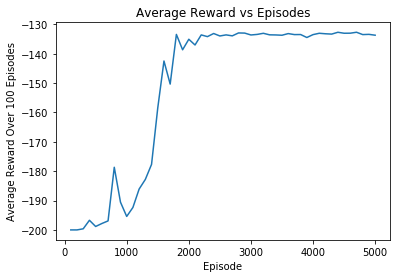

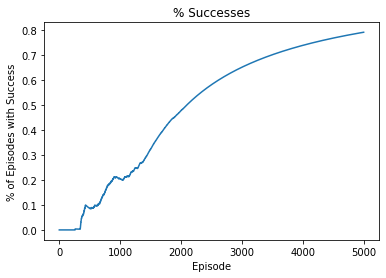

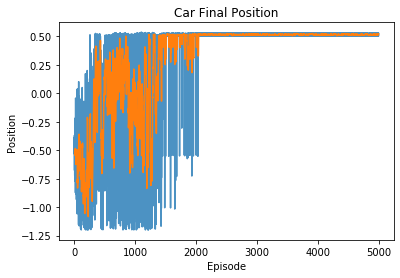

In [6]:
import pandas as pd 

plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward Over 100 Episodes')
plt.title('Average Reward vs Episodes')
plt.show()   
plt.close()  

plt.plot(successes)
plt.xlabel('Episode')
plt.ylabel('% of Episodes with Success')
plt.title('% Successes')
plt.show()
plt.close()

p = pd.Series(position)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.show()

As a sanity check (and nice visualization), run the code below to play both the first and last episode of the learned policy consecutively. You should see a noticeable difference in the policies, with the last episode resulting in a success.

Insert an image of the car reaching the flag into your Latex document.



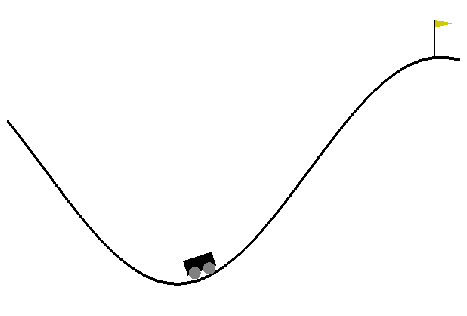

In [7]:
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

## 2.2 Deep Q-Learning

Now we will take a deep learning approach by using a neural network to represent the Q values. The network architecture is given in the PDF.

Note that we have given a `reward_shaping` function to aid with the training process.

Refer back to HW 4 or the [Pytorch tutorials](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) if you need a refresher on PyTorch.

Implement `QNetwork`, `choose_action`, `reward_shaping`, and `DeepQLearning`. Feel free to use any Pytorch functions you might need.

In [0]:
"""
Imports you might need
"""
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from datetime import datetime
import glob, os

In [0]:
class QNetwork(nn.Module):
    """
    Qnetwork approximates Q values. 
    
    The input is the state space, which for this problem is 2 values: [position, velocity]
    The output is the action space, which for this problem is: [left, no movt, right]
    """
    
    def __init__(self):
        super(QNetwork, self).__init__()
        self.state_space = 2 # TODO fill in
        self.action_space = 3 # TODO fill in
        self.hidden = 100 # TODO fill in
        self.l1 = nn.Linear(self.state_space, self.hidden, bias=False) # TODO fill in, don't use a bias term
        self.hid = nn.Linear(self.hidden, self.hidden, bias=False) # TODO fill in, don't use a bias term
        self.l2 = nn.Linear(self.hidden, self.action_space, bias=False) # TODO fill in, don't use a bias term
    
    def forward(self, x):    
        model = torch.nn.Sequential(
            # TODO fill in
            self.l1,
            nn.Tanh(),
            self.hid,
            nn.Tanh(),
            self.l2
        )

        return model(x)

In [0]:
def choose_action(Q, epsilon):
    """
    Choose an action according to an epsilon greedy strategy.
 
    Hint: torch.max can be useful to find the argmax: https://pytorch.org/docs/stable/torch.html#torch.max

    Args:
        Q (Tensor): Pytorch tensor representing Q values for the network
        epsilon (float): the probability of choosing a random action
  
    Returns:
        action (int): the chosen action
    """    
    action = 0
    """TODO start your code"""

    rand_action = np.random.rand()
    if rand_action > epsilon:
        # optimal action
        action = torch.argmax(Q).item()
    else:
        # random action
        action = np.random.choice([0, 1, 2])
    
    """TODO end your code"""

    return action 


def reward_shaping(next_state):
    """
    Alternative reward function based on next_state:
        - the reward is [position] + 0.5
        - if the car has succeeded in reaching the flag (i.e. position >=0.5), add +1 on top of the reward just computed.
    
    Also described in the PDF.
    
    Returns:
        reward (float)
    """
    reward = 0
    """TODO begin your code"""
    reward = next_state[0]+0.5
    if next_state[0] >= 0.5:
        reward = reward+1
    """TODO end your code """
    
    return reward

In [0]:
def DeepQlearning(env, qnetwork, objective, optimizer, scheduler, epsilon, discount, decay_rate, max_episodes):
    """
    The main Q-learning function, utilizing the functions and QNetwork implemented above.

    Args:
        env: the RL environment
        qnetwork (QNetwork): an instance of the QNetwork class defined above 
        objective (torch.nn.modules.loss): the objective (loss) function
        optimizer (torch.optim.sgd): the optimization method
        scheduler (torch.optim.lr_scheduler): adaptive learning rate method
        epsilon (float): the probability of choosing a random action
        discount (float): the discount factor, may be referred to as gamma
        decay_rate (float): the amount to decay epsilon
        max_episodes (int): the maximum number of episodes to run
        
    Returns:
        position (list): a list of the final car position states reached over the episodes
        success_history (list): a list of the ratio of successes achieved over the episodes
        frames (list): a list of video frames to render
    """
    successes = 0
    position = []
    success_history = []
    frames = []
    steps = 200
    for episode in range(max_episodes):
        episode_loss = 0
        episode_reward = 0
        state = env.reset()

        for s in range(steps):

            if episode == (max_episodes - 1) or episode==1:
                frames.append(env.render(mode = 'rgb_array'))
            
            state = Variable(torch.from_numpy(np.asarray(state))).type(torch.FloatTensor)  # use Variable to make it gradable
            Q = qnetwork.forward(state)  # TODO get Q by making the forward pass using state
            # Determine next action
            action = choose_action(Q, epsilon) # TODO fill in

            # Get next_state and done using env.step(), see http://gym.openai.com/docs/#environments for reference
            next_state, _, done, _ = env.step(action) # TODO fill in

            # Use reward_shaping() to get the reward
            reward = reward_shaping(next_state)
            
            # Find max Q for t+1 state using the Q1 qnetwork
            next_state = Variable(torch.from_numpy(next_state)).type(torch.FloatTensor)  # use Variable to make it gradable
            Q1 = qnetwork.forward(next_state)  # TODO make the forward pass using next_state 
            maxQ1 = torch.max(Q1)  # TODO fill in

            # Create Q_target value for training the policy, see slide 12 of https://www.seas.upenn.edu/~cis520/lectures/RL_recitation.pdf
            Q_target = Q.clone()
            Q_target = Variable(Q_target)
            Q_target[action] = reward + torch.mul(maxQ1.detach(), discount) # TODO fill in

            # Calculate loss between Q and Q_target value using objective param
            loss = objective(Q, Q_target) # TODO fill in 


            ########################################

            """TODO begin your code"""
            # Update qnetwork policy (backwards pass) using optimizer param

            # optimizer.zero_grad()
            qnetwork.zero_grad()
            loss.backward()
            optimizer.step()

            """TODO end your code"""

            episode_loss += loss.item()
            episode_reward += reward
            
            if done:
                if next_state[0] >= 0.5:
                    epsilon = update_epsilon(epsilon, decay_rate) #TODO update epsilon using decay_rate
                    scheduler.step()
                    successes += 1

                if (episode+1)%100==0:
                    print('Episode: ', episode+1, 'Reward per Episode: ',episode_reward)

                success_history.append(successes/(episode+1))
                position.append(next_state[0])

                break
            else:
                state = next_state

    return position, success_history, frames



Run Deep Q Learning, using your functions implemented above and the parameters given below. Use `nn.MSELoss()` as the objective, `optim.SGD()` with the given `learning_rate` as the optimizer, and `optim.lr_scheduler.StepLR()` with the given `step_size` and `gamma` as the learning rate scheduler. 

In [12]:
env = gym.make('MountainCar-v0')
env.seed(1); torch.manual_seed(1); np.random.seed(1)
state = env.reset()
# Parameters
epsilon = 0.3
discount = 0.99
max_episodes = 1000
learning_rate = 0.001 # the learning rate for optimizer
step_size = 1 # the step size for scheduler
gamma = 0.9 # the gamma for scheduler, be sure not to mix this up with discount
decay_rate = 0.95 # decay rate for epsilon

# Initialize Policy
qnetwork = QNetwork() # TODO fill in
objective = nn.MSELoss() # TODO fill in 
optimizer = torch.optim.SGD(qnetwork.parameters(), lr=learning_rate) # TODO fill in 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma) # TODO fill in

# Run Deep Q Learning 
deep_position, deep_successes, deep_frames = DeepQlearning(env, qnetwork, objective, optimizer, scheduler, epsilon, discount, decay_rate, max_episodes)

Episode:  100 Reward per Episode:  27.58236967352578
Episode:  200 Reward per Episode:  3.9848307314254425
Episode:  300 Reward per Episode:  15.699339268406785
Episode:  400 Reward per Episode:  9.537955710140649
Episode:  500 Reward per Episode:  2.873256875926053
Episode:  600 Reward per Episode:  20.00949486105269
Episode:  700 Reward per Episode:  12.127743271355662
Episode:  800 Reward per Episode:  46.410280160349856
Episode:  900 Reward per Episode:  16.431081222195466
Episode:  1000 Reward per Episode:  9.446781309501535


Plot the % successes and car final position over the episodes using the code below and insert the figures into your Latex document:

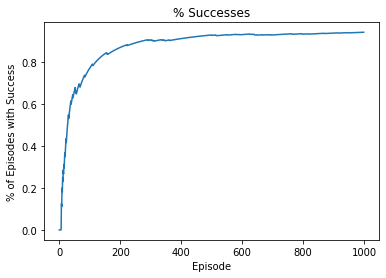

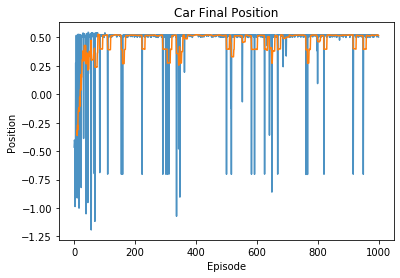

In [13]:
import pandas as pd 

plt.plot(deep_successes)
plt.xlabel('Episode')
plt.ylabel('% of Episodes with Success')
plt.title('% Successes')
plt.show()
plt.close()

p = pd.Series(deep_position)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.show()

Again as a sanity check, run the code below to play both the first and last episode of the learned policy consecutively. You should see a noticeable difference in the policies, with the last episode resulting in a success.

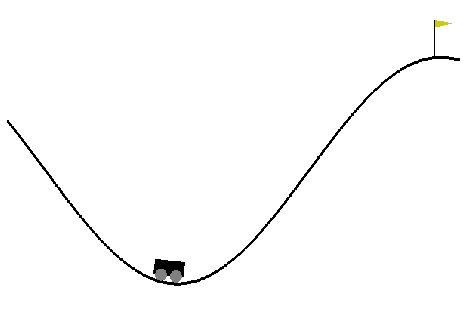

In [14]:
plt.figure(figsize=(deep_frames[0].shape[1] / 72.0, deep_frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(deep_frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(deep_frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(deep_frames), interval = 50)
HTML(ani.to_jshtml())

## 2.3 Questions


1.  As part of the Deep QLearning implementation, we have provided a $\mathsf{reward\_shaping}$ function to aid in the learning process. Briefly describe what it is doing. Compare this to the original reward structure in part 2.1 -- why do you think this modification of the reward is helpful?

2. Compare the **Success Rate** and **Car Final Position** plots between your two implementations. Which algorithm is learning a successful policy more quickly? Briefly comment on potential reasons for any differences in performance.

Insert your responses in your Latex document.


# Question 3: Autoencoders 

In this question, we will try fitting the Fashion MNIST dataset to a vanilla, fully connected autoencoder. You won't have to experiment with the architecture, as the architecture is already given in the PDF of the homework. Please use Google Colab to run this section to maintain consistency across the class. 

Refer back to HW 4 or the [Pytorch tutorials](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) if you need a refresher on PyTorch.

*Tip: To speed up model training, be sure to go to:"Runtime->Change runtime type->Hardware accelerator: GPU" to use a GPU*

In [0]:
'''
Imports. 
'''

import os
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

In [16]:
'''
Seed set for reproducibility. Do not change this.
'''

torch.manual_seed(42)

## 3.1 Constructing the Autoencoder

This section is where you are supposed to code up the architecture and train a simple autoencoder. Helper functions are provided for you.

### Helper Functions to Visualize Images 


In [0]:
def convert_to_img(x):
    '''
    Converts the output of the autoencoder network to a batch of images that can be viewed. 
    Essentially reverses the transformation applied to the input dataset. 

    Args:
        x: Output layer of the autoencoder, with the batch size

    Returns:
        x: Viewable image, reshaped to be an array of images.

    '''
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

# Making a Grid to print images on screen  
  
def imshow(img,epoch):
    '''
    Converts a torchvision grid to be viewable on matplotlib. 
    Args:
        img: of the type Torchvision.utils.grid(img). 
        epoch: the epoch that this image was recorded on 

    Returns:
        Returns nothing. Plots the Grid.

    '''

    npimg = img.numpy()
    
    figure(num=None, figsize=(8, 6), dpi=150, edgecolor='k')
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Reconstruction of last minibatch of epoch "+str(epoch))
    
def data_to_model(img):
    '''
    Takes in the image batch given by the dataloader and returns batch that can be fed into the model
    
    Args:
        img: Image batch obtained from the dataloader iterator 
        
    Returns:
        img: Image batch that can be fed into the model
    '''
    img = img.view(img.size(0), -1)
    img = Variable(img).cuda()
    
    return img 


### Data pre-processing and Dataloader generation
The given helper code below applies a pre-processing transformation and also generates the iterator through which the data will be sampled from.

In [0]:
# Image transform, normalization 
mean = 0.5 #TODO: Enter value of mean to be used
std = 0.5 #TODO: Enter value of std to be used

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

In [0]:
#Dataset Generation

batch_size = 128 #TODO: Enter a suitable batch size.

dataset = full_data = FashionMNIST('./data',download=True, transform=img_transform) # Loading the dataset 

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # Dataset that is mainly used for training

full_dataload = iter(DataLoader(full_data,batch_size=len(full_data),shuffle=False)) # Dataset object to get the full dataset returned when iterated.
                                                                                    # This will be used to calculate the reconstruction errors, and to plot latent spaces. 

full_imgs, full_label = full_dataload.next()

In [0]:
'''
This is the autoencoder class where you are supposed to set up the architecture, and the forward pass.
The constructor is setup so that it takes in a variable 
'''

class autoencoder(nn.Module):
    def __init__(self,n=64):
        super(autoencoder, self).__init__()
        '''
        The __init__ takes in 'n' which denotes the size of the bottleneck layer. By default, it is set to 64.
        '''
        ### TODO: Implement the architecture with an encoder layer and a decoder layer 
        #         as defined in the problem set PDF. Be sure to use bias terms here.
        #
        
        #### Start your code here ####
        self.encoder = nn.Sequential(
            nn.Linear(784,256),
            nn.ReLU(inplace=True),
            nn.Linear(256,64),
            nn.ReLU(inplace=True),
            nn.Linear(64,n),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(n,64),
            nn.ReLU(inplace=True),
            nn.Linear(64,256),
            nn.ReLU(inplace=True),
            nn.Linear(256,784),
            nn.Tanh()
        )
        #### End your code here 
        
    def forward(self, x):
      
        ### TODO: Implement the forward pass, by taking in the input batch of images x, and returning 
        #         the output of the network 
        
        ### Start your code here ###
        x = self.encoder(x)
        x = self.decoder(x)

        ### End your code here ###
        
        return x


In [0]:
'''
You will implement the main training loop here 

'''

def train(num_epochs,dataloader,model,criterion,optimizer):
    '''
    Takes in all necessary parameters to train the model and returns the model and the loss curves.

    Args:
      num_epochs: Number of epochs to train for 
      dataloader: The training dataloader object that was given in the helper code 
      model: The autoencoder model from the class
      criterion: Loss criterion
      Optimizer: Optimizer to be used 
    Returns:
      model: trained model 
      loss_curve: A list of mean epoch losses over the range of epochs
    '''

    #### TODO: In this function, you'll implement the main training loop. 
    # device initialization
    device = torch.device('cuda')
    model = model.to(device)

    loss_curve = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for data in dataloader:
            img, label = data
            #### TODO: Implement the forward pass, the loss calculation, and the optimization processes.
            #          The helper function data_to_model will be useful here.
            #          Calculate the losses and add them to the total epoch loss to find the mean epoch loss 
            #### Start your Code Here 

            # get cuda data for input
            x_img = data_to_model(img)

            # use model, calculate loss
            x_img_reconstruct = model(x_img)
            output = x_img_reconstruct
            loss = criterion(x_img_reconstruct, x_img)
            epoch_loss += loss

            # one step iter
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #### End your code Here

        epoch_loss = epoch_loss / len(dataloader)
        loss_curve.append(epoch_loss)
        print('epoch [{}/{}], mean epoch loss:{:.4f}'.format(epoch + 1, num_epochs, epoch_loss))

        if epoch % 10 == 0:
            # For every 10 epochs, take the output of the last minibatch of the epoch and print the reconstruction.
            pic = convert_to_img(output.cpu().data)
            imshow(torchvision.utils.make_grid(pic),epoch)

    return model, loss_curve 


### Main code for Question 3.1
Answer question 3.1 by running this main code. You are asked to plot the training curve of the autoencoder, with **bottleneck layer size being 2**. You are also asked to plot the reconstructions of the autoencoder while it is training at epochs 0, 10, and 20. The optimizer we will use is `torch.optim.Adam()` and the criterion we will use is `nn.MSELoss()`.

-------TRAINING WITH HIDDEN LAYER SIZE ------  2
epoch [1/25], mean epoch loss:0.1586
epoch [2/25], mean epoch loss:0.1229
epoch [3/25], mean epoch loss:0.1168
epoch [4/25], mean epoch loss:0.1136
epoch [5/25], mean epoch loss:0.1115
epoch [6/25], mean epoch loss:0.1103
epoch [7/25], mean epoch loss:0.1089
epoch [8/25], mean epoch loss:0.1080
epoch [9/25], mean epoch loss:0.1068
epoch [10/25], mean epoch loss:0.1060
epoch [11/25], mean epoch loss:0.1047
epoch [12/25], mean epoch loss:0.1045
epoch [13/25], mean epoch loss:0.1034
epoch [14/25], mean epoch loss:0.1030
epoch [15/25], mean epoch loss:0.1025
epoch [16/25], mean epoch loss:0.1018
epoch [17/25], mean epoch loss:0.1016
epoch [18/25], mean epoch loss:0.1004
epoch [19/25], mean epoch loss:0.1001
epoch [20/25], mean epoch loss:0.0999
epoch [21/25], mean epoch loss:0.0992
epoch [22/25], mean epoch loss:0.0992
epoch [23/25], mean epoch loss:0.0988
epoch [24/25], mean epoch loss:0.0982
epoch [25/25], mean epoch loss:0.0982


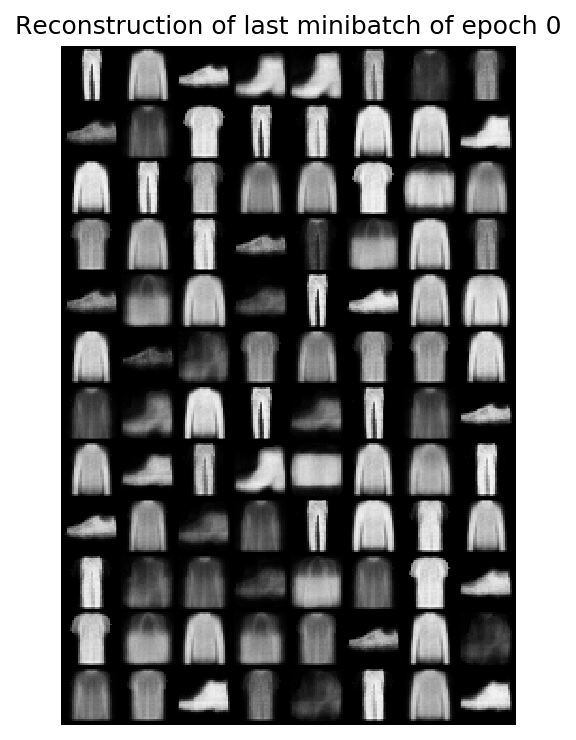

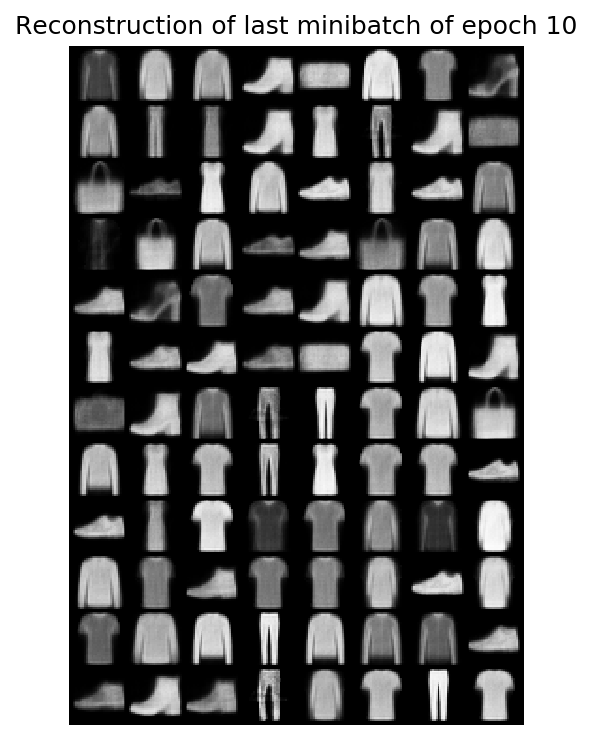

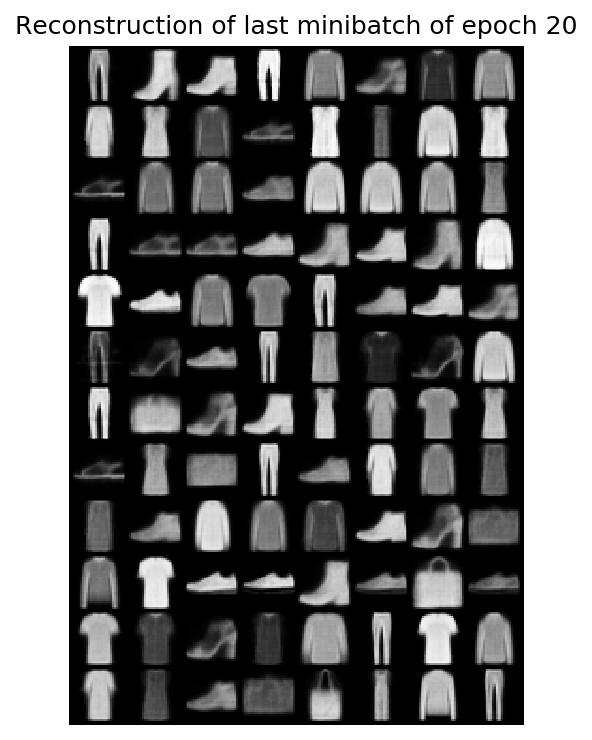

In [22]:

num_epochs = 25 # TODO: Give in a suitable number for number of epochs 
learning_rate = 1e-3 #TODO: Give in a suitable learning rate for the optimizer. 

print('-------TRAINING WITH HIDDEN LAYER SIZE ------ ', 2)

#TODO: Create a model object of the autoencoder class with bottleneck layer size (n) being 2. 
#      Define the criterion and the optimizer. Call the train function. 

model = autoencoder(n=2) #TODO
criterion = nn.MSELoss() #TODO
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #TODO

trained_model, loss_curve = train(num_epochs,dataloader,model,criterion,optimizer) #TODO


The code for plotting the training curve is given below to you.

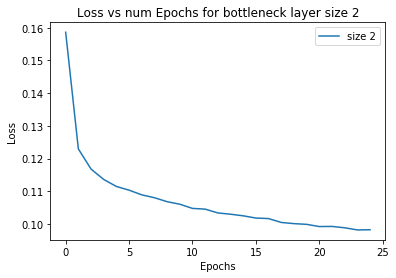

In [23]:
epochs = np.arange(num_epochs)
plt.figure()
plt.plot(epochs,loss_curve,label='size 2')
plt.title("Loss vs num Epochs for bottleneck layer size 2")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## 3.2 Latent Space Decomposition

In this section, you are asked to plot the latent space of the encoded inputs of the model that was trained above in 3.1. You are asked to plot the encoding of the full image set corresponding to the classes 0 and 7. Use the `full_imgs` image batch that was given as a part of the Dataloader helper code. 

In [0]:
##### TODO: 
#           Pass the extacted image batches for class labels 0 and 7 (img_0, img_7) 
#           into trained_model trained in Section 3.1, and extract the *encoding* 
#           only (ie. the output of the forward layer). 
#           You will want to use the data_to_model helper function defined above.
#           At the end, have your encoding for classes 0 and 7 as 'enc_0' and 'enc_7'
#           Hint: To read out a Variable var, use var.detach().cpu().numpy()

img_0 = full_imgs[full_label==0]
img_7 = full_imgs[full_label==7]

### Start your code here ###
device = torch.device('cuda')
encoder = trained_model.encoder.to(device)

x_img_0 = data_to_model(img_0)
x_img_7 = data_to_model(img_7)

enc_0_device = encoder(x_img_0)
enc_7_device = encoder(x_img_7)

enc_0 = enc_0_device.detach().cpu().numpy() # TODO: Find this
enc_7 = enc_7_device.detach().cpu().numpy() # TODO: Find this

### End your code here ###

The plotting code for plotting the encoding of the classes 0 and 7 is given below to you. Use this to generate the plot.

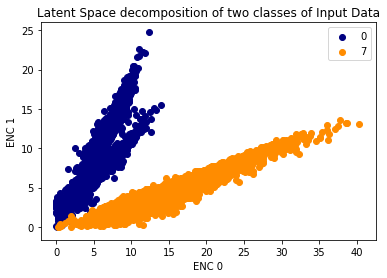

In [25]:
'''
Plotting latent space of encoding of model trained in 3.1
'''
plt.figure()
plt.scatter(enc_0[:,0],enc_0[:,1],color='navy',label='0')
plt.scatter(enc_7[:,0],enc_7[:,1],color='darkorange',label='7')
plt.legend()
plt.xlabel('ENC 0')
plt.ylabel('ENC 1')
plt.title("Latent Space decomposition of two classes of Input Data")
plt.show()

### Latex question 3.2:
1) You will now plot the latent space of this autoencoder, which is essentially the encoding that is obtained for any given input. In this problem, the latent space is the output of the ReLU 3, after the Fully connected layer 3. Use your learnt model from the previous section, and plot the 2D latent space for the images with the class label 0 and for the images with the class label 7.

2) From the latent space plot, explain what the encoding has done to the inputs. How is this effect related to what PCA does? Why is this useful? 

## 3.3 Reconstruction error vs Bottleneck Layer:

In this section, you build on top of the code you wrote in section 3.1. Here, we vary the size of the bottleneck layer to see how that affects the reconstructions. Here, we will only observe the reconstruction error corresponding to the entire image set of class 0.

### Reconstruction Error
Fill in the function below that takes in the model and the image batch from the dataloader and computes the reconstruction error (`nn.MSELoss`).

In [0]:
#### TODO: Fill in the method below that takes in the model and the image batch from the dataloader
#          and returns the reconstruction error. The helper function data_to_model will be useful.
#          Hint: To read out a Variable var, use var.detach().cpu().numpy()
 
def reconstruction_error(model,img):
    '''
    Args:
      model: Input model 
      img: Image batch from the dataloader

    Returns:
      err: Reconstruction Error, a scalar quantity.
    '''
    err = 0
    ##### Start your code here #####
    device = torch.device('cuda')
    model = model.to(device)

    x_img = data_to_model(img).float()
    x_img_reconstruct = model(x_img)

    orig_img_flat = x_img.detach().cpu()
    reconstruct_img_flat = x_img_reconstruct.detach().cpu()

    print('orig_img_flat.shape', orig_img_flat.shape)
    print('reconstruct_img_flat.shape', reconstruct_img_flat.shape)

    mse = nn.MSELoss()
    loss = mse(reconstruct_img_flat, orig_img_flat)

    err = loss.detach().cpu().numpy()
    #### End your code ###

    return err

  

In [0]:
# test block

# num_epochs = 25 #TODO: Give a suitable number 
# learning_rate = 1e-3 #TODO: Give a suitable number 

# bottleneck_layer_size = [2, 8, 32, 64] #TODO: Insert a list of bottleneck layer sizes to train the network on

# rec_err = [] # List of reconstruction errors to be obtained for the multiple sizes
# losses = [] # List of training curves to be obtained for the multiple sizes

# img_rec = full_imgs[full_label==0] #Obtains the reconstruction image batch.

# # initialize optim and loss
# device = torch.device('cuda')
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# print(type(img_rec))
# err = reconstruction_error(trained_model,img_rec)
# print(err)

### Main code for 3.3

Run this main code to generate the plots required to answer question 5.3. Use the full_imgs image batch defined above to generate the reconstruction image batch, which is essentially the images belonging to class 0.

-------TRAINING WITH HIDDEN LAYER SIZE ------  2
epoch [1/25], mean epoch loss:0.1741
epoch [2/25], mean epoch loss:0.1258
epoch [3/25], mean epoch loss:0.1187
epoch [4/25], mean epoch loss:0.1151
epoch [5/25], mean epoch loss:0.1121
epoch [6/25], mean epoch loss:0.1102
epoch [7/25], mean epoch loss:0.1088
epoch [8/25], mean epoch loss:0.1082
epoch [9/25], mean epoch loss:0.1070
epoch [10/25], mean epoch loss:0.1065
epoch [11/25], mean epoch loss:0.1053
epoch [12/25], mean epoch loss:0.1047
epoch [13/25], mean epoch loss:0.1041
epoch [14/25], mean epoch loss:0.1041
epoch [15/25], mean epoch loss:0.1035
epoch [16/25], mean epoch loss:0.1025
epoch [17/25], mean epoch loss:0.1029
epoch [18/25], mean epoch loss:0.1017
epoch [19/25], mean epoch loss:0.1018
epoch [20/25], mean epoch loss:0.1008
epoch [21/25], mean epoch loss:0.1007
epoch [22/25], mean epoch loss:0.1000
epoch [23/25], mean epoch loss:0.0998
epoch [24/25], mean epoch loss:0.0998
epoch [25/25], mean epoch loss:0.0996
orig_img_f

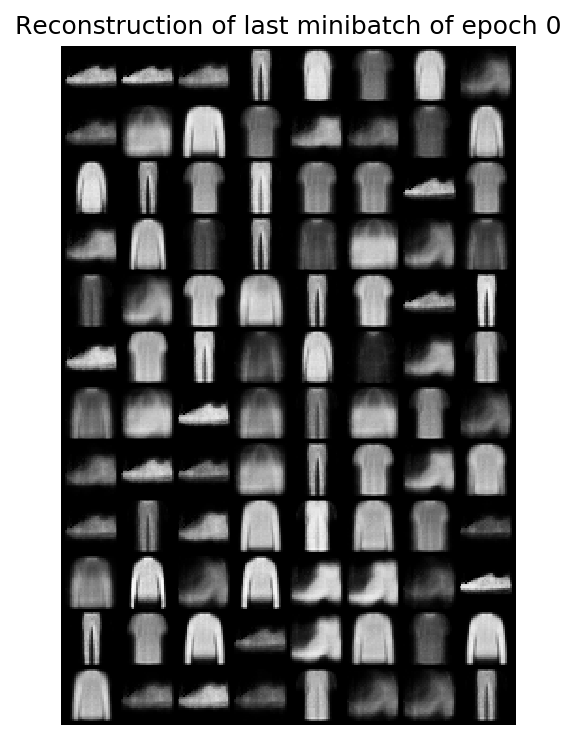

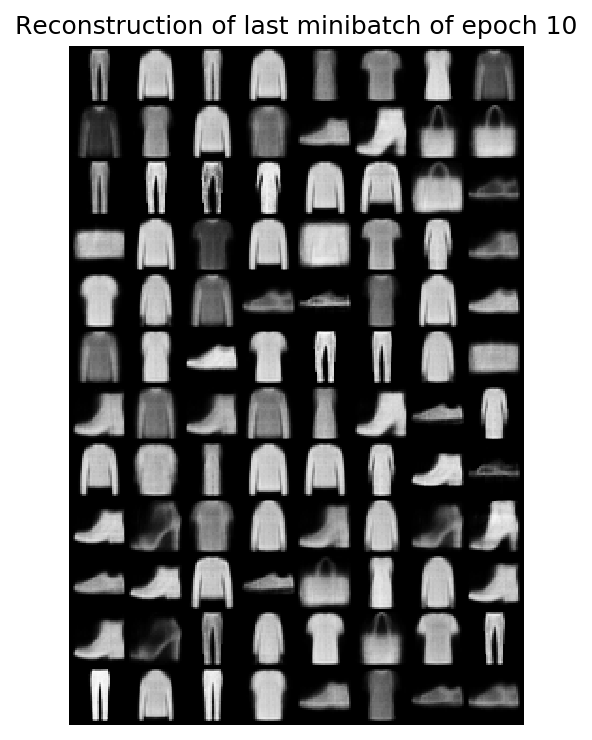

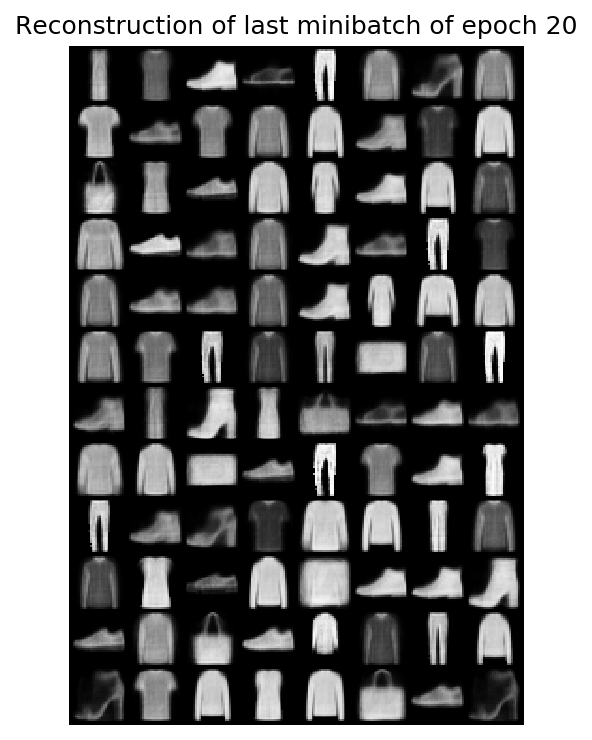

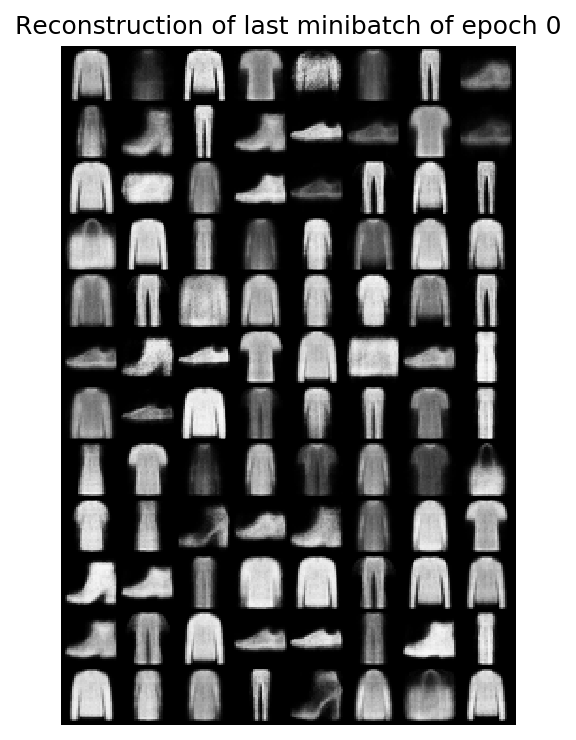

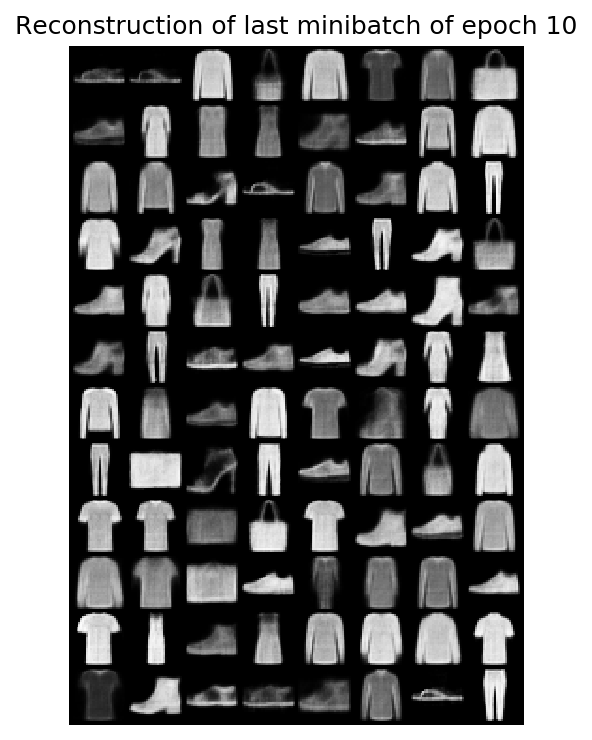

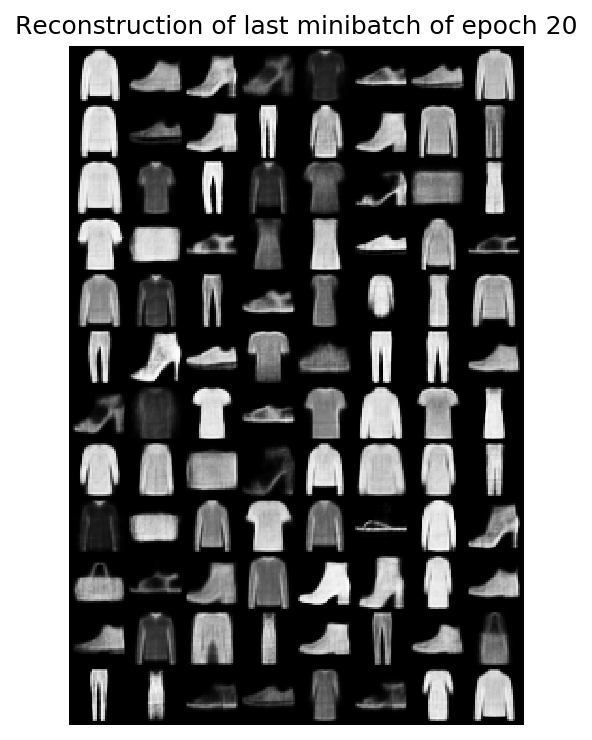

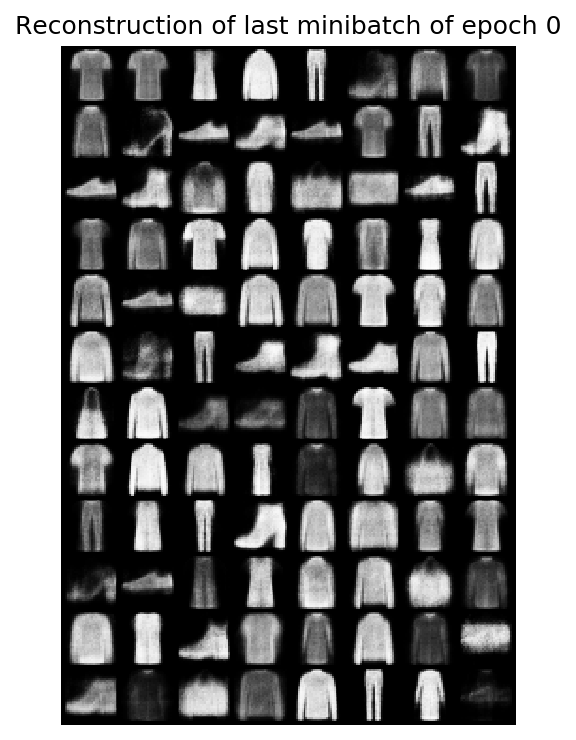

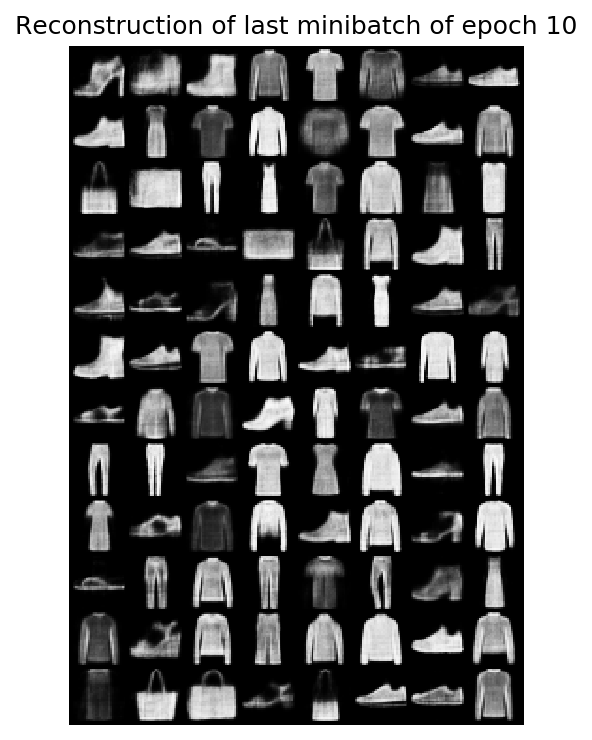

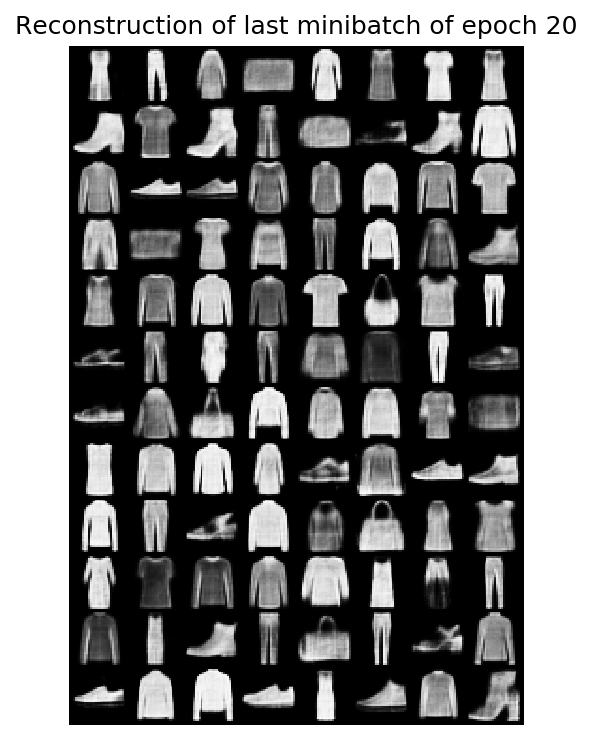

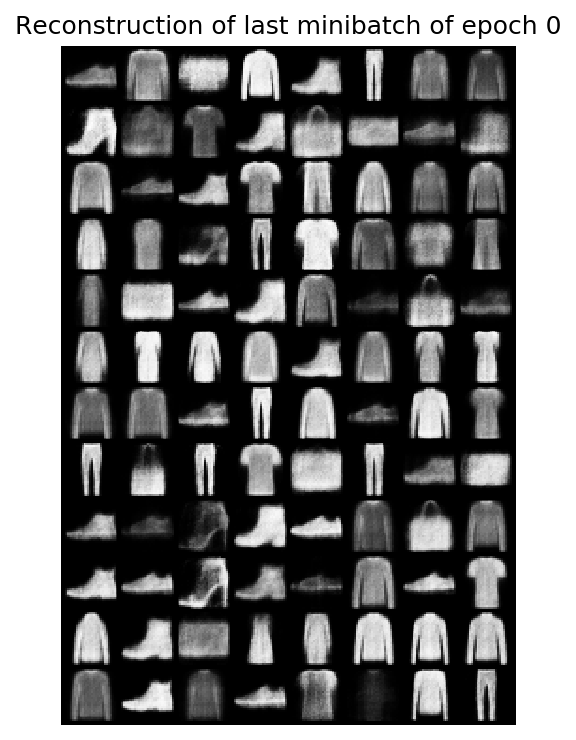

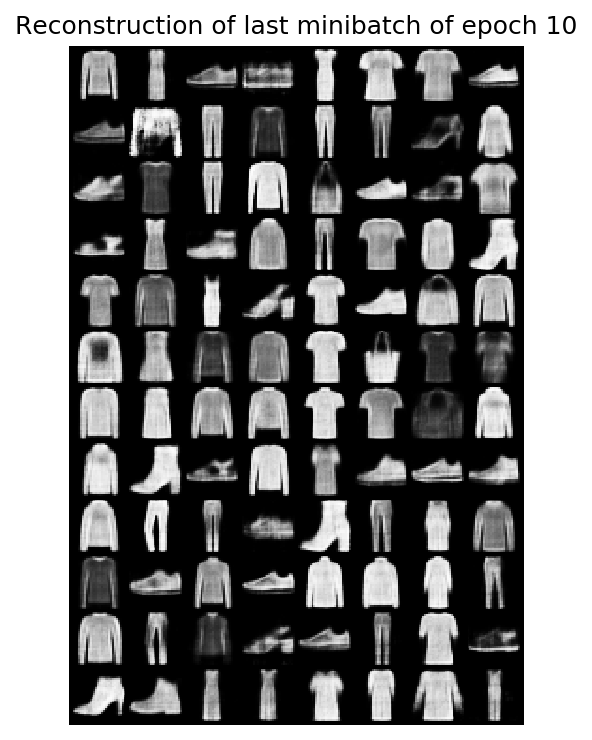

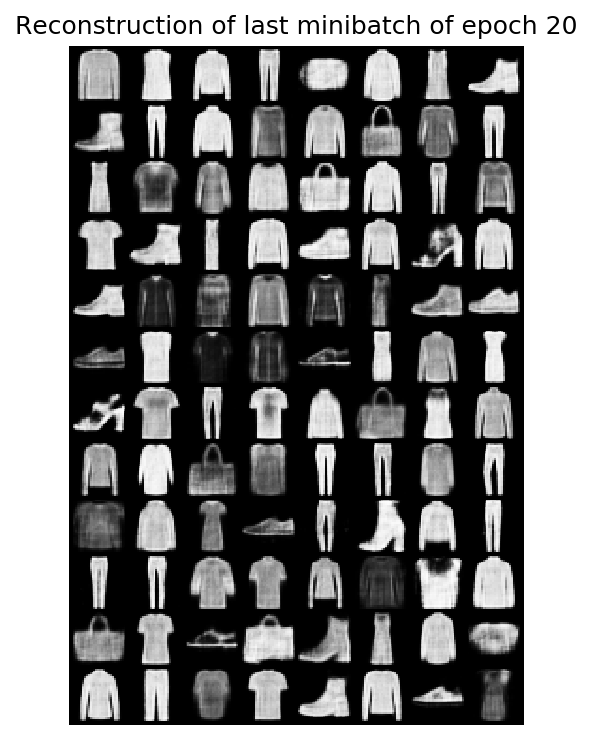

In [28]:
# Main code


num_epochs = 25 #TODO: Give a suitable number 
learning_rate = 1e-3 #TODO: Give a suitable number 

bottleneck_layer_size = [2, 8, 32, 64] #TODO: Insert a list of bottleneck layer sizes to train the network on

rec_err = [] # List of reconstruction errors to be obtained for the multiple sizes
losses = [] # List of training curves to be obtained for the multiple sizes

img_rec = full_imgs[full_label==0] #Obtains the reconstruction image batch.

# initialize optim and loss
device = torch.device('cuda')
criterion = nn.MSELoss()

for size in bottleneck_layer_size:
    print('-------TRAINING WITH HIDDEN LAYER SIZE ------ ', size)
    ##### TODO: Initialize the model with the size of the bottleneck layer, define the criterion, 
    #           the optimizer and call the train method that was defined in section 5.1. Pass the trained
    #           model and the image batch for class 0 to the reconstruction error method, and obtain the 
    #           reconstruction error, and append to the list rec_err. Append the training loss to the list, losses.

    ### Start your code here ####
    model = autoencoder(n=size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    trained_model, loss_curve = train(num_epochs,dataloader,model,criterion,optimizer)

    losses.append(loss_curve)

    ele_rec_err = reconstruction_error(trained_model,img_rec)
    rec_err.append(ele_rec_err)
  
    ### End your code here ####



The code for plotting the training curves is provided below:

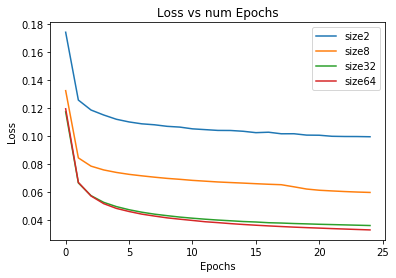

In [29]:
'''Learning curves for all bottleneck layers''' 

epochs = np.arange(num_epochs)
plt.figure()
count = 0
for curve in losses:
    plt.plot(epochs, curve, label='size'+str(bottleneck_layer_size[count]))
    count += 1
plt.title("Loss vs num Epochs")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

The plotting code for plotting the variation of the reconstruction error with the bottleneck layer size:

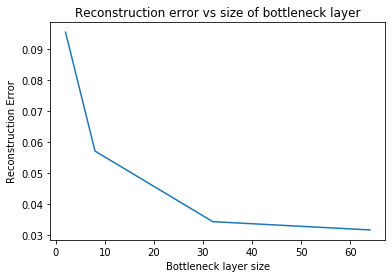

In [30]:

''' Reconstruction Error vs Hidden layer size '''

plt.figure()
plt.plot(bottleneck_layer_size,rec_err)
plt.title("Reconstruction error vs size of bottleneck layer")
plt.xlabel("Bottleneck layer size")
plt.ylabel("Reconstruction Error")
plt.show()

### Latex question 3.3:

1) In this section, you will extend your code in Part 1 to a variable size bottleneck layer. Use your existing code in Part 1 and run the same for the bottleneck layer sizes $[2,8,32,64]$. Record the training curves and the final reconstruction errors for the input images belonging to the class label 0 for each of the sizes. Report the combined training curves (mean epoch loss vs epochs) for all the configurations. Also report the reconstructed images for Epoch 20 for each of the configurations.

2) Plot the mean reconstruction error of the 6 different trained models when the input images belong to the class label 0, with respect to the size of the bottleneck layer. What are you observing? How does what you see relate to PCA? What does this tell you about how you can potentially work with a high-dimensional data-space?

# Turning it in

**This notebook will not be autograded, so no need to comment out code outside of functions.**

1. Download this notebook as a `hw8.py` file
  - go to "File -> Download .py"
  
2. Submit `hw8.py` file to Gradescope (you can do this as many times as you'd like before the deadline)

# Problem 1

**Below are the codes used for problem 1**

In [0]:
import numpy as np

In [0]:
def prob(s,a,s_next):
    '''
    P: [s,s',a]
    s: 0,1,2,3,4
    s': 0,1,2,3,4
    a: f,b (0,1)

    return: p
    '''
    P = np.zeros((5,5,2))
    P[0,0,0] = 0.1 # p(s'=0|s=0,a=f) = 0.1
    P[0,0,1] = 0.9 # p(s'=0|s=0,a=b) = 0.9
    P[0,1,0] = 0.9 # p(s'=1|s=0,a=f) = 0.9
    P[0,1,1] = 0.1 # p(s'=1|s=0,a=b) = 0.1

    P[1,0,0] = 0.1 # p(s'=0|s=1,a=f) = 0.1
    P[1,0,1] = 0.9 # p(s'=0|s=1,a=b) = 0.9
    P[1,2,0] = 0.9 # p(s'=2|s=1,a=f) = 0.9
    P[1,2,1] = 0.1 # p(s'=2|s=1,a=b) = 0.1

    P[2,0,0] = 0.1 # p(s'=0|s=2,a=f) = 0.1
    P[2,0,1] = 0.9 # p(s'=0|s=2,a=b) = 0.9
    P[2,3,0] = 0.9 # p(s'=3|s=2,a=f) = 0.9
    P[2,3,1] = 0.1 # p(s'=3|s=2,a=b) = 0.1

    P[3,0,0] = 0.1 # p(s'=0|s=3,a=f) = 0.1
    P[3,0,1] = 0.9 # p(s'=0|s=3,a=b) = 0.9
    P[3,4,0] = 0.9 # p(s'=4|s=3,a=f) = 0.9
    P[3,4,1] = 0.1 # p(s'=4|s=3,a=b) = 0.1

    P[4,0,0] = 0.1 # p(s'=0|s=4,a=f) = 0.1
    P[4,0,1] = 0.9 # p(s'=0|s=4,a=b) = 0.9
    P[4,4,0] = 0.9 # p(s'=4|s=4,a=f) = 0.9
    P[4,4,1] = 0.1 # p(s'=4|s=4,a=b) = 0.1

    p = P[s,s_next,a]
    return p

def reward(s,a,s_next):
    '''
    R: [s,s',a]
    s: 0,1,2,3,4
    s': 0,1,2,3,4
    a: f,b (0,1)

    return: r
    '''
    R = np.zeros((5,5,2))
    R[0,0,0] = 2
    R[0,0,1] = 2

    R[1,0,0] = 2
    R[1,0,1] = 2

    R[2,0,0] = 2
    R[2,0,1] = 2

    R[3,0,0] = 2
    R[3,0,1] = 2

    R[4,0,0] = 2
    R[4,0,1] = 2

    R[4,4,0] = 10
    R[4,4,1] = 10

    r = R[s,s_next,a]
    return r

## 1.2

In [0]:
# initial v
V = np.array([0.1, 0.1, 0.1, 0.1, 0.1])

In [34]:
gama = 0.9
EPOCH = 100 # epoch for iterations of update
for n in range(EPOCH):
    # iter all 0-4 states
    for i in range(5):
        s = i  # 0 to 4
        v_a = np.array([0.0, 0.0])  # candidate v for actions
        # iter f, b actions
        for ele_a in range(2):
            a = ele_a  # 0 or 1

            # sum over all posible states
            s_next1 = i+1
            s_next2 = 0
            if i == 4:
                s_next1 = 4
            v_a[a] = prob(s,a,s_next1)*(reward(s,a,s_next1)+gama*V[s_next1]) + prob(s,a,s_next2)*(reward(s,a,s_next2)+gama*V[s_next2])
        # find max in v_a: find best action
        v_optim = np.max(v_a)
        V[i] = v_optim

print('V:', V)

V: [40.74144108 45.52441677 51.42931677 58.71931677 67.71931677]


## 1.3

In [0]:
V_optim = V
Q = np.array([0.1, 0.1, 0.1, 0.1, 0.1])
policy = np.array([0., 0., 0., 0., 0.])

In [36]:
gama = 0.9
EPOCH = 1 # epoch for iterations of update
for n in range(EPOCH):
    # iter all 0-4 states
    for i in range(5):
        s = i  # 0 to 4
        v_a = np.array([0.0, 0.0])  # candidate v for actions
        # iter f, b actions
        for ele_a in range(2):
            a = ele_a  # 0 or 1

            # sum over all posible states
            s_next1 = i+1
            s_next2 = 0
            if i == 4:
                s_next1 = 4
            v_a[a] = prob(s,a,s_next1)*(reward(s,a,s_next1)+gama*V_optim[s_next1]) + prob(s,a,s_next2)*(reward(s,a,s_next2)+gama*V_optim[s_next2])
        # find max in v_a: find best action
        Q[i] = np.max(v_a)
        a_optim = np.argmax(v_a)
        policy[i] = a_optim

print('Q:', Q)
print('Policy:', policy)

Q: [40.74150728 45.52447628 51.42937628 58.71937628 67.71937628]
Policy: [0. 0. 0. 0. 0.]
